<a name="top" id="top"></a>

<div align="center">
    <h1>Introduction to Mathematical Programming</h1>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Universities Space Research Association</i>
    <br>
    <i>NASA QuAIL</i>
    <br>
    <br>
    <a href="https://github.com/pedromxavier">Pedro Maciel Xavier</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Computer Science &amp; Systems Engineering Program, Federal University of Rio de Janeiro</i>
    <br>
    <i>PSR Energy Consulting &amp; Analytics</i>
    <br>
    <br>
    <a href="https://colab.research.google.com/github/JuliaQUBO/QUBONotebooks/blob/main/notebooks_jl/1-MathProg.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="#installation">
        <img src="https://img.shields.io/badge/⚙️-Installation_Instructions-blue" alt="Installation Instructions"/>
    </a>
    <a href="https://secquoia.github.io/">
        <img src="https://img.shields.io/badge/🌲⚛️🌐-SECQUOIA-blue" alt="SECQUOIA"/>
    </a>
</div>

### Activate Environment

In [ ]:
import Pkg
# Activate the environment in the current folder.
Pkg.activate(".") 

## Introduction to Mathematical Programming

### Modeling
The solution to optimization problems requires the development of a mathematical model. Here we will model an example given in the lecture and see how an integer program can be solved practically.
This example will use as modeling language **[JuMP](http://jump.dev/)**.
This open-source Julia package provides flexible access to different solvers and a general modeling framework for linear and nonlinear integer programs.
The examples solved here will make use of open-source solvers **[GLPK](https://www.gnu.org/software/glpk/)** and **[CLP/CBC](https://projects.coin-or.org/Cbc)** for linear and mixed-integer linear programming, **[IPOPT](https://coin-or.github.io/Ipopt/)** for interior point (non)linear programming, **[BONMIN](https://www.coin-or.org/Bonmin/)** for convex integer nonlinear programming, and **[COUENNE](https://projects.coin-or.org/Couenne)** for nonconvex (global) integer nonlinear programming.

#### Problem statement

Suppose there is a company that produces two different products, A and B, which can be sold at different values, $\$5.5$ and $\$2.1$ per unit, respectively.
The company only counts with a single machine with electricity usage of at most 17kW/day. Producing each A and B consumes $8\text{kW}/\text{day}$ and $2\text{kW}/\text{day}$, respectively.
Besides, the company can only produce at most $2$ more units of B than A per day.

### Linear Programming
This is a valid model, but it would be easier to solve if we had a mathematical representation.
Assuming the units produced of A are $x_1$ and of B are $x_2$ we have

$$
\begin{array}{rl}
    \displaystyle%
    \max_{x_1, x_2} & 5.5x_1 + 2.1x_2 \\
    \textrm{s.t.}   & x_2 \le x_1 + 2 \\
                    & 8x_1 + 2x_2 \le 17 \\
                    & x_1, x_2 \ge 0
\end{array}
$$

In [ ]:
# Loading in the Plots Package
try
    @eval using Plots
catch
    println("Installing Plots")
    Pkg.add("Plots")
    @eval using Plots
end

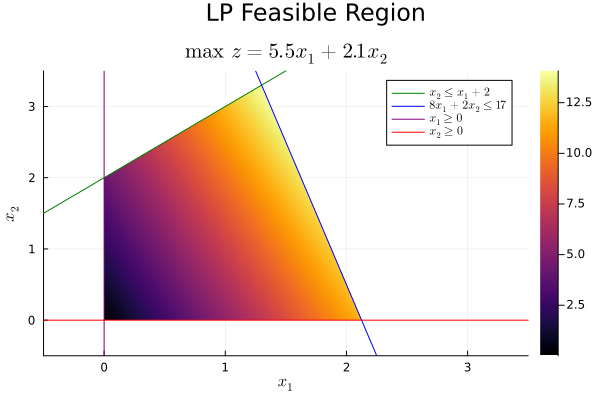

In [3]:
function plot_lp(;ns::Integer = 1_000, sol = nothing)
    # Create empty plot
    plt = plot(;
        plot_title="LP Feasible Region",
        plot_titlevspan=0.1,
    )

    # Generate the feasible region plot of this problem
    x1 = x2 = range(-0.5, 3.5; length = ns)

    # Objective: min 5.5x₁ + 2.1x₂
    z(x1, x2) = 5.5x1 + 2.1x2

    # Constraints
    isfeasible(x1, x2) = (x1 >= 0)      && # Bound: x1 ≥ 0
                         (x2 >= 0)      && # Bound: x2 ≥ 0
                         (x2 <= x1 + 2) && # Constraint 1: x₂ ≤ x₁ + 2
                         (8x1 + 2x2 <= 17) # Constraint 2: 8 x₁ + 2 x₂ ≤ 17

    # Heatmap function
    f(x1, x2) = ifelse(isfeasible(x1, x2), z(x1, x2), NaN)

    # Plot feasible region
    heatmap!(
        plt, x1, x2, f;
        legend=:topright,
        title=raw"$ \max ~ z = 5.5 x_1 + 2.1 x_2 $",
        xlims=extrema(x1),
        ylims=extrema(x2),
        xlabel=raw"$ x_1 $",
        ylabel=raw"$ x_2 $",
    )

    # Make plots of constraints
    plot!(plt, x1, (x1) -> x1 + 2;
        label=raw"$ x_2 \leq x_1 + 2 $",
        color=:green,
    )
    plot!(plt, x1, (x1) -> (17 - 8x1) / 2;
        label=raw"$ 8 x_1 + 2 x_2 \leq 17 $",
        color=:blue,
    )

    # Nonnegativitivy constraints
    plot!(plt, zeros(ns), x2;
        label=raw"$ x_1 \geq 0 $",
        color=:purple,
    )
    plot!(plt, x1, zeros(ns);
        label=raw"$ x_2 \geq 0 $",
        color=:red,
    )

    if sol !== nothing
        # Optimal solution
        scatter!(plt, [sol[1]], [sol[2]];
            label=raw"$ (x_1^\ast, x_2^\ast) $",
            marker_z=z,
            markershape=:star8,
        )
    end

    return plt
end

plot_lp()

In [4]:
# Loading in the modeling framework JuMP
try 
  @eval using JuMP
catch
  println("Installing JuMP")
  Pkg.add("JuMP")
  @eval using JuMP
end

In [5]:
# Define empty model
lp_model = Model()

# Define the variables
@variable(lp_model, x[1:2] >= 0)

# Define the objective function
@objective(lp_model, Max, 5.5x[1] + 2.1x[2])

# Define the constraints
@constraint(lp_model, c1, x[2] <= x[1] + 2)

@constraint(lp_model, c2, 8x[1] + 2x[2] <= 17)

# Print the model
print(lp_model)

In [6]:
# Loading in the GLPK solver
try 
  @eval using GLPK
catch
  println("Installing GLPK")
  Pkg.add("GLPK")
  @eval using GLPK
end

In [7]:
# Here we solve the optimization problem with GLPK
set_optimizer(lp_model, GLPK.Optimizer)

set_silent(lp_model)

optimize!(lp_model)

# Retrieve solution value for "x"
lp_x = value.(x)

# Display solution of the problem
println(solution_summary(lp_model))
println("* x = $lp_x")

solution_summary(; result = 1, verbose = false)
├ solver_name          : GLPK
├ Termination
│ ├ termination_status : OPTIMAL
│ ├ result_count       : 1
│ ├ raw_status         : Solution is optimal
│ └ objective_bound    : Inf
├ Solution (result = 1)
│ ├ primal_status        : FEASIBLE_POINT
│ ├ dual_status          : FEASIBLE_POINT
│ ├ objective_value      : 1.40800e+01
│ └ dual_objective_value : 1.40800e+01
└ Work counters
  └ solve_time (sec)   : 3.99995e-03
* x = [1.3, 3.3]


We observe that the optimal solution of this problem is $x_1 = 1.3$, $x_2 = 3.3$, leading to a profit of $14.08$.

In [8]:
# Loading in the CBC solver
try 
  @eval using Cbc
catch
  println("Installing Cbc")
  Pkg.add("Cbc")
  @eval using Cbc
end

In [9]:
# With Cbc instead:
set_optimizer(lp_model, Cbc.Optimizer)

set_silent(lp_model)

optimize!(lp_model)

# Retrieve solution value for "x"
lp_x = value.(x)

# Display solution of the problem
println(solution_summary(lp_model))
println("* x = $lp_x")

solution_summary(; result = 1, verbose = false)
├ solver_name          : COIN Branch-and-Cut (Cbc)
├ Termination
│ ├ termination_status : OPTIMAL
│ ├ result_count       : 1
│ ├ raw_status         : Cbc_status          = finished - check isProvenOptimal or isProvenInfeasible to see if solution found (or check value of best solution)
Cbc_secondaryStatus = unset (status_ will also be -1)

│ └ objective_bound    : 1.40800e+01
├ Solution (result = 1)
│ ├ primal_status        : FEASIBLE_POINT
│ ├ dual_status          : NO_SOLUTION
│ ├ objective_value      : 1.40800e+01
│ └ relative_gap         : 0.00000e+00
└ Work counters
  ├ solve_time (sec)   : 3.99995e-03
  └ node_count         : 0
* x = [1.3, 3.3]
Presolve 0 (-2) rows, 0 (-2) columns and 0 (-4) elements
Optimal - objective value 14.08
After Postsolve, objective 14.08, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 14.08 - 0 iterations time 0.002, Presolve 0.00


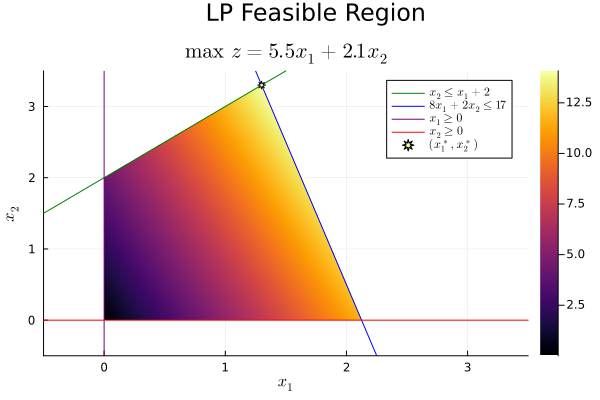

In [10]:
plot_lp(;sol = lp_x)

The solvers GLPK and CLP implement the simplex method (with many improvements) by default, but we can also use an interior point method through the solver IPOPT (interior point optimizer). IPOPT is able to solve not only linear but also nonlinear problems.

In [11]:
# Loading in the Ipopt solver
try 
  @eval using Ipopt
catch
  println("Installing Ipopt")
  Pkg.add("Ipopt")
  @eval using Ipopt
end

In [12]:
# Using Ipopt for an interior point method
set_optimizer(lp_model, Ipopt.Optimizer)
set_silent(lp_model)

optimize!(lp_model)

# Retrieve solution value for "x"
lp_x = value.(x)

# Display solution of the problem
println(solution_summary(lp_model))
println("* x = $lp_x")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

solution_summary(; result = 1, verbose = false)
├ solver_name          : Ipopt
├ Termination
│ ├ termination_status : LOCALLY_SOLVED
│ ├ result_count       : 1
│ └ raw_status         : Solve_Succeeded
├ Solution (result = 1)
│ ├ primal_status        : FEASIBLE_POINT
│ ├ dual_status          : FEASIBLE_POINT
│ ├ objective_value      : 1.40800e+01
│ └ dual_objective_value : 1.40800e+01
└ Work counters
  ├ solve_time (sec)   : 1.97000e-01
  └ barrier_iterations : 8
* x = [1.3000000135344931, 3.300000029213091]


We obtain the same result as previously, but notice that the interior point method reports a solution subject to a certain tolerance, given by its convergence properties when it can get infinitesimally close (but not directly at) the boundary of the feasible region.

## Let's go back to the slides

### Integer Programming

Now let's consider that only integer units of each product can be produced, namely

$$
\begin{array}{rl}
    \displaystyle%
    \max_{x_1, x_2} & 5.5x_1 + 2.1x_2 \\
    \textrm{s.t.}   & x_2 \leq x_1 + 2 \\
                    & 8x_1 + 2x_2 \leq 17 \\
                    & x_1, x_2 \geq 0 \\
                    & x_1, x_2 \in \mathbb{Z}
\end{array}
$$

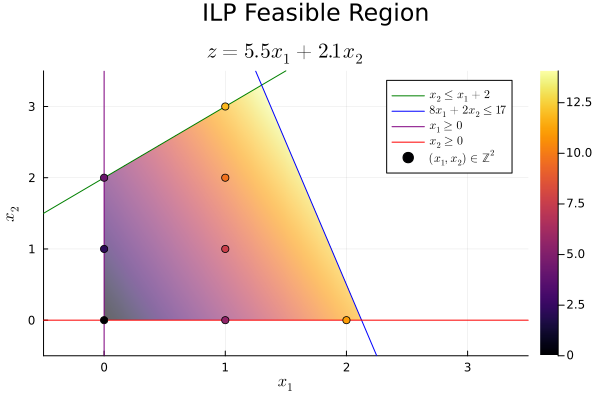

In [13]:
function plot_ilp(;ns::Integer = 1_000, sol = nothing)
    # Create empty plot
    plt = plot(;
        plot_title="ILP Feasible Region",
        plot_titlevspan=0.1,
    )

    # Generate the feasible region plot of this problem
    x1 = x2 = range(-0.5, 3.5; length = ns)

    # Objective: min 5.5x₁ + 2.1x₂
    z(x1, x2) = 5.5x1 + 2.1x2

    # Constraints
    isfeasible(x1, x2) = (x1 >= 0)      && # Bound: x1 ≥ 0
                         (x2 >= 0)      && # Bound: x2 ≥ 0
                         (x2 <= x1 + 2) && # Constraint 1: x₂ ≤ x₁ + 2
                         (8x1 + 2x2 <= 17) # Constraint 2: 8 x₁ + 2 x₂ ≤ 17

    # Optimal Solution
    isoptimal(x1, x2) = (sol !== nothing) && (x1 ≈ sol[1] && x2 ≈ sol[2]) 

    # Heatmap functions
    f(x1, x2) = ifelse(isfeasible(x1, x2), z(x1, x2), NaN)
    g(x1, x2) = ifelse(isfeasible(x1, x2), 1.0, NaN)

    # Plot relaxed feasible region
    heatmap!(
        plt, x1, x2, f;
        legend=:topright,
        title=raw"$ z = 5.5 x_1 + 2.1 x_2 $",
        xlims=extrema(x1),
        ylims=extrema(x2),
        xlabel=raw"$ x_1 $",
        ylabel=raw"$ x_2 $",
    )

    # Dim relaxed feasible region
    heatmap!(
        plt, x1, x2, g;
        alpha=0.4,
        color=:white,
        colorbar_entry=false,
        xlims=extrema(x1),
        ylims=extrema(x2),
    )

    # Make plots of constraints
    plot!(plt, x1, (x1) -> x1 + 2;
        label=raw"$ x_2 \leq x_1 + 2 $",
        color=:green,
    )
    plot!(plt, x1, (x1) -> (17 - 8x1) / 2;
        label=raw"$ 8 x_1 + 2 x_2 \leq 17 $",
        color=:blue,
    )

    # Nonnegativitivy constraints
    plot!(plt, zeros(ns), x2;
        label=raw"$ x_1 \geq 0 $",
        color=:purple,
    )
    plot!(plt, x1, zeros(ns);
        label=raw"$ x_2 \geq 0 $",
        color=:red,
    )

    # Feasible solutions
    xi = []
    xj = []

    for i = 0:4, j = 0:4
        if isfeasible(i, j) && !isoptimal(i, j)
            push!(xi, i)
            push!(xj, j)
        end
    end

    scatter!(plt, xi, xj;
        label=raw"$ (x_1, x_2) \in \mathbb{Z}^2 $",
        marker_z=z,
    )

    if sol !== nothing
        # Optimal solution
        scatter!(plt, [sol[1]], [sol[2]];
            label=raw"$ (x_1^\ast, x_2^\ast) $",
            marker_z=z,
            markershape=:star8,
        )
    end

    return plt
end

plot_ilp()

In [14]:
# Copy model
ilp_model = copy(lp_model)

# Retrieve variable reference
x = ilp_model[:x]

# Add integrality contraint: x₁, x₂ ∈ ℤ
set_integer.(x)

# Print the model
print(ilp_model)

In [15]:
set_optimizer(ilp_model, Cbc.Optimizer)
set_silent(ilp_model)

optimize!(ilp_model)

print(solution_summary(ilp_model))

# Retrieve 
ilp_x = value.(x)

# Display solution of the problem
println(solution_summary(ilp_model))
println("* x = $ilp_x")

solution_summary(; result = 1, verbose = false)
├ solver_name          : COIN Branch-and-Cut (Cbc)
├ Termination
│ ├ termination_status : OPTIMAL
│ ├ result_count       : 1
│ ├ raw_status         : Cbc_status          = finished - check isProvenOptimal or isProvenInfeasible to see if solution found (or check value of best solution)
Cbc_secondaryStatus = search completed with solution

│ └ objective_bound    : 1.18000e+01
├ Solution (result = 1)
│ ├ primal_status        : FEASIBLE_POINT
│ ├ dual_status          : NO_SOLUTION
│ ├ objective_value      : 1.18000e+01
│ └ relative_gap         : 0.00000e+00
└ Work counters
  ├ solve_time (sec)   : 2.59998e-02
  └ node_count         : 0solution_summary(; result = 1, verbose = false)
├ solver_name          : COIN Branch-and-Cut (Cbc)
├ Termination
│ ├ termination_status : OPTIMAL
│ ├ result_count       : 1
│ ├ raw_status         : Cbc_status          = finished - check isProvenOptimal or isProvenInfeasible to see if solution found (or check val

Here the solution becomes $x_1 = 1, x_2 = 3$ with an objective of $11.8$.

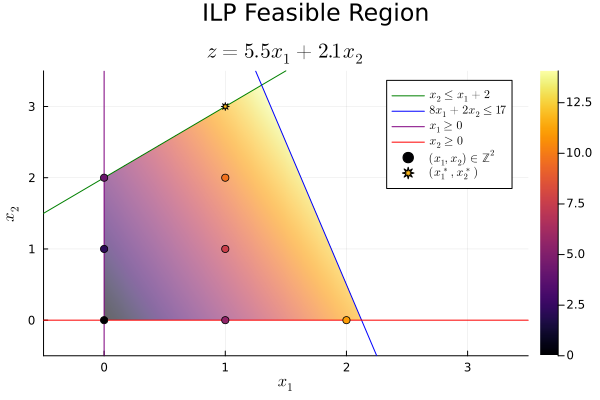

In [16]:
plot_ilp(; sol = ilp_x)

## Let's go back to the slides

#### Enumeration
Enumerating all the possible solutions in this problem might be very efficient (there are only 8 feasible solutions), this we only know from the plot. Assuming that we had as upper bounds for the variables 4, the possible solutions would be 16. With a larger number of variables, the enumeration turns to be impractical. For $n$ binary variables (we can always "binarize" the integer variables), the number of possible solutions is $2^n$.

In many other applications, the possible solutions come from permutations of the integer variables (e.g., assignment problems), which grow as $n!$ with the size of the input.

This growth makes the problem grow out of control relatively quickly.

In [17]:
# Loading in SpecialFunctions package that provides a range of mathematical functions
try 
  @eval using SpecialFunctions
catch
  println("Installing SpecialFunctions")
  Pkg.add("SpecialFunctions")
  @eval using SpecialFunctions
end

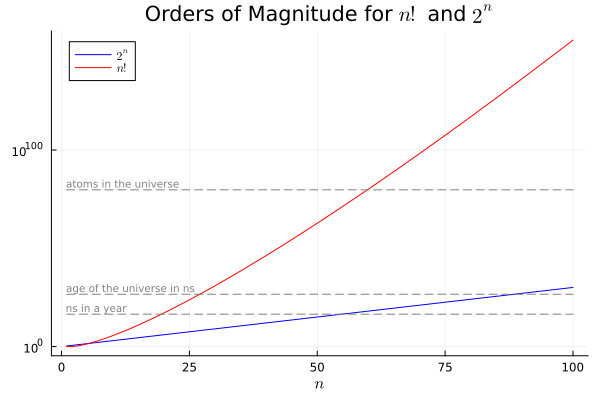

In [18]:
function plot_growth(n::Integer = 100)
    i = 1:n

    plt = plot(;
        title=raw"Orders of Magnitude for $ n! $ and $ 2^n $",
        xlabel=raw"$ n $",
        legend=:topleft,
        yscale=:log10,
    )

    plot!(plt, i, (i) -> 2.0^i; label=raw"$ 2^n $", color=:blue)
    plot!(plt, i, SpecialFunctions.gamma; label=raw"$ n! $", color=:red)

    plot!(plt, i, (i) -> 3.154E16; color=:gray, label = nothing, linestyle = :dash)
    annotate!(plt, first(i), 3.154E16, text("ns in a year", :gray, :left, :bottom, 7))

    plot!(plt, i, (i) -> 4.3E26; color=:gray, label = nothing, linestyle = :dash)
    annotate!(plt, first(i), 4.3E26, text("age of the universe in ns", :gray, :left, :bottom, 7))

    plot!(plt, i, (i) -> 6E79; color=:gray, label = nothing, linestyle = :dash)
    annotate!(plt, first(i), 6E79, text("atoms in the universe", :gray, :left, :bottom, 7))

    return plt
end

plot_growth()

## Let's go back to the slides

### Integer convex nonlinear programming

The following constraint: "the production of B minus 1, squared, can only be smaller than 2 minus the production of A" can be incorporated  in the following convex integer nonlinear program, 

$$
\begin{array}{rl}
    \displaystyle%
    \max_{x_1, x_2} & 5.5x_1 + 2.1x_2        \\
    \textrm{s.t.}   & x_2 \leq x_1 + 2       \\
                    & 8x_1 + 2x_2 \leq 17    \\
                    & (x_2-1)^2 \leq 2 - x_1 \\
                    & x_1, x_2 \geq 0        \\
                    & x_1, x_2 \in \mathbb{Z}
\end{array}
$$

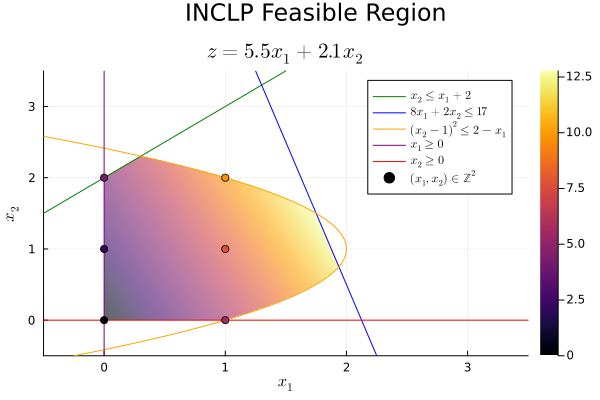

In [19]:
function plot_icnlp(; ns::Integer = 1_000, sol = nothing)
    # Create empty plot
    plt = plot(;
        plot_title="INCLP Feasible Region",
        plot_titlevspan=0.1,
    )

    # Generate the feasible region plot of this problem
    x1 = x2 = range(-0.5, 3.5; length = ns)

    # Objective: min 5.5x₁ + 2.1x₂
    z(x1, x2) = 5.5x1 + 2.1x2

    # Constraints
    isfeasible(x1, x2) = (x1 >= 0)           && # Bound: x1 ≥ 0
                         (x2 >= 0)           && # Bound: x2 ≥ 0
                         (x2 <= x1 + 2)      && # Constraint 1: x₂ ≤ x₁ + 2
                         (8x1 + 2x2 <= 17)   && # Constraint 2: 8 x₁ + 2 x₂ ≤ 17
                         ((x2 - 1)^2 <= 2 - x1) # Constraint 3: (x₂ - 1)² ≤ 2 - x₁

    # Optimal Solution
    isoptimal(x1, x2) = (sol !== nothing) && (x1 ≈ sol[1] && x2 ≈ sol[2]) 

    # Heatmap functions
    f(x1, x2) = ifelse(isfeasible(x1, x2), z(x1, x2), NaN)
    g(x1, x2) = ifelse(isfeasible(x1, x2), 1.0, NaN)

    # Plot relaxed feasible region
    heatmap!(
        plt, x1, x2, f;
        legend=:topright,
        title=raw"$ z = 5.5 x_1 + 2.1 x_2 $",
        xlims=extrema(x1),
        ylims=extrema(x2),
        xlabel=raw"$ x_1 $",
        ylabel=raw"$ x_2 $",
    )

    # Dim relaxed feasible region
    heatmap!(
        plt, x1, x2, g;
        alpha=0.4,
        color=:white,
        colorbar_entry=false,
        xlims=extrema(x1),
        ylims=extrema(x2),
    )

    # Make plots of constraints
    plot!(plt, x1, (x1) -> x1 + 2;
        label=raw"$ x_2 \leq x_1 + 2 $",
        color=:green,
    )
    plot!(plt, x1, (x1) -> (17 - 8x1) / 2;
        label=raw"$ 8 x_1 + 2 x_2 \leq 17 $",
        color=:blue,
    )
    plot!(plt, 2 .- (x1 .- 1) .^ 2, x1,;
        label=raw"$ (x_2 - 1)^2 \leq 2 - x_1 $",
        color=:orange,
    )

    # Nonnegativitivy constraints
    plot!(plt, zeros(ns), x2;
        label=raw"$ x_1 \geq 0 $",
        color=:purple,
    )
    plot!(plt, x1, zeros(ns);
        label=raw"$ x_2 \geq 0 $",
        color=:red,
    )

    # Feasible solutions
    xi = []
    xj = []

    for i = 0:4, j = 0:4
        if isfeasible(i, j) && !isoptimal(i, j)
            push!(xi, i)
            push!(xj, j)
        end
    end

    scatter!(plt, xi, xj;
        label=raw"$ (x_1, x_2) \in \mathbb{Z}^2 $",
        marker_z=z,
    )

    if sol !== nothing
        # Optimal solution
        scatter!(plt, [sol[1]], [sol[2]];
            label=raw"$ (x_1^\ast, x_2^\ast) $",
            marker_z=z,
            markershape=:star8,
        )
    end

    return plt
end

plot_icnlp()

In [20]:
# Define the model
icnlp_model = copy(ilp_model)

# Retrieve variable reference
x = icnlp_model[:x]

# (x₂ - 1)² ≤ 2 - x₁
@constraint(icnlp_model, c3, (x[2] - 1)^2 <= 2 - x[1])

# Print the model
print(icnlp_model)

In [ ]:
# BONMIN Solver
try 
  @eval using AmplNLWriter
catch
  println("Installing AmplNLWriter")
  Pkg.add("AmplNLWriter")
  @eval using AmplNLWriter
end

try 
  @eval using Bonmin_jll
catch
  println("Installing Bonmin_jll")
  Pkg.add("Bonmin_jll")
  @eval using Bonmin_jll
end

const Bonmin_Optimizer = () -> AmplNLWriter.Optimizer(Bonmin_jll.amplexe);

In [35]:
set_optimizer(icnlp_model, Bonmin_Optimizer)

optimize!(icnlp_model)

icnlp_x = value.(x)

println(solution_summary(icnlp_model))
println("* x = $icnlp_x")

Bonmin 1.8.9 using Cbc 2.10.8 and Ipopt 3.14.13
bonmin: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -12.775        9 0.005
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1      INFEAS 0.24999981       16 0.019
NLP0014I             2         OPT -12.4125        5 0.004
NLP0014I             3         OPT -9.7000002        6 0.004
NLP0014I             4         OPT -9.7000001        6 0
NLP0014I             5      INFEAS 0.24999981       16 0.017

In this case the optimal solution becomes $x_1 = 1, x_2 = 2$ with an objective of $9.7$.

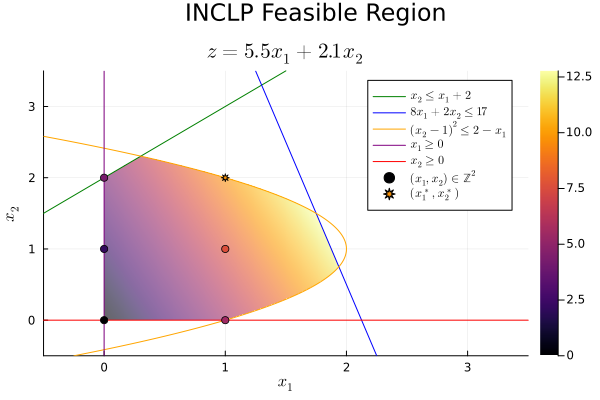

In [23]:
plot_icnlp(; sol = icnlp_x)

### Integer non-convex programming

The last constraint "the production of B minus 1 squared can only be greater than the production of A plus one half" can be incorporated  in the following convex integer nonlinear program

$$
\begin{array}{rl}
    \displaystyle%
    \max_{x_1, x_2} & 5.5x_1 + 2.1x_2 \\
    \textrm{s.t.}   & x_2 \leq x_1 + 2 \\
                    & 8x_1 + 2x_2 \leq 17 \\
                    & (x_2-1)^2 \leq 2-x_1\\
                    & (x_2-1)^2 \geq \frac{1}{2} +x_1\\
                    & x_1, x_2 \geq 0 \\
                    & x_1, x_2 \in \mathbb{Z}
\end{array}
$$

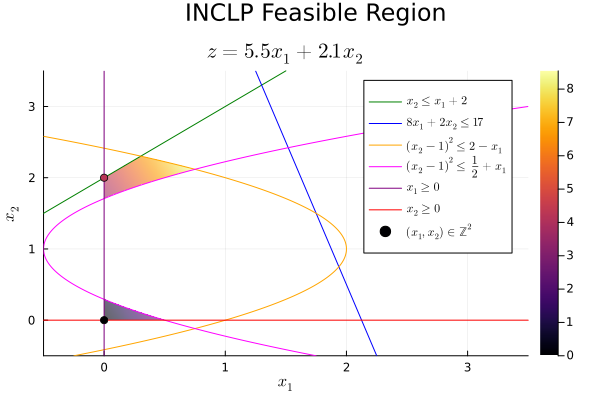

In [24]:
function plot_incnlp(; ns::Integer = 1_000, sol = nothing)
    # Create empty plot
    plt = plot(;
        plot_title="INCLP Feasible Region",
        plot_titlevspan=0.1,
    )

    # Generate the feasible region plot of this problem
    x1 = x2 = range(-0.5, 3.5; length = ns)

    # Objective: min 5.5x₁ + 2.1x₂
    z(x1, x2) = 5.5x1 + 2.1x2

    # Constraints
    isfeasible(x1, x2) = (x1 >= 0)              && # Bound: x1 ≥ 0
                         (x2 >= 0)              && # Bound: x2 ≥ 0
                         (x2 <= x1 + 2)         && # Constraint 1: x₂ ≤ x₁ + 2
                         (8x1 + 2x2 <= 17)      && # Constraint 2: 8 x₁ + 2 x₂ ≤ 17
                         ((x2 - 1)^2 <= 2 - x1) && # Constraint 3: (x₂ - 1)² ≤ 2 - x₁
                         ((x2 - 1)^2 >= 1/2 + x1)  # Constraint 4: (x₂ - 1)² ≤ 1/2 + x₁

    # Optimal Solution
    isoptimal(x1, x2) = (sol !== nothing) && (x1 ≈ sol[1] && x2 ≈ sol[2])

    # Heatmap functions
    f(x1, x2) = ifelse(isfeasible(x1, x2), z(x1, x2), NaN)
    g(x1, x2) = ifelse(isfeasible(x1, x2), 1.0, NaN)

    # Plot relaxed feasible region
    heatmap!(
        plt, x1, x2, f;
        legend=:topright,
        title=raw"$ z = 5.5 x_1 + 2.1 x_2 $",
        colobar_label=raw"$ z $",
        xlims=extrema(x1),
        ylims=extrema(x2),
        xlabel=raw"$ x_1 $",
        ylabel=raw"$ x_2 $",
    )

    # Dim relaxed feasible region
    heatmap!(
        plt, x1, x2, g;
        alpha=0.4,
        color=:white,
        colorbar_entry=false,
        xlims=extrema(x1),
        ylims=extrema(x2),
    )

    # Make plots of constraints
    plot!(plt, x1, (x1) -> x1 + 2;
        label=raw"$ x_2 \leq x_1 + 2 $",
        color=:green,
    )
    plot!(plt, x1, (x1) -> (17 - 8x1) / 2;
        label=raw"$ 8 x_1 + 2 x_2 \leq 17 $",
        color=:blue,
    )
    plot!(plt, 2 .- (x1 .- 1) .^ 2, x1,;
        label=raw"$ (x_2 - 1)^2 \leq 2 - x_1 $",
        color=:orange,
    )
    plot!(plt, -1/2 .+ (x1 .- 1) .^ 2, x1,;
        label=raw"$ (x_2 - 1)^2 \leq \frac{1}{2} + x_1 $",
        color=:magenta,
    )

    # Nonnegativitivy constraints
    plot!(plt, zeros(ns), x2;
        label=raw"$ x_1 \geq 0 $",
        color=:purple,
    )
    plot!(plt, x1, zeros(ns);
        label=raw"$ x_2 \geq 0 $",
        color=:red,
    )

    # Feasible solutions
    xi = []
    xj = []

    for i = 0:4, j = 0:4
        if isfeasible(i, j) && !isoptimal(i, j)
            push!(xi, i)
            push!(xj, j)
        end
    end

    scatter!(plt, xi, xj;
        label=raw"$ (x_1, x_2) \in \mathbb{Z}^2 $",
        marker_z=z,
    )

    if sol !== nothing
        # Optimal solution
        scatter!(plt, [round(sol[1])], [round(sol[2])];
            label=raw"$ (x_1^\ast, x_2^\ast) $",
            marker_z=z,
            markershape=:star8,
        )
    end

    return plt
end

plot_incnlp()

In [25]:
# Define the model
incnlp_model = copy(icnlp_model)

# Retrieve variable reference
x = incnlp_model[:x]

# (x₂ - 1)² ≥ 1/2 + x₁
@constraint(incnlp_model, c4, (x[2] - 1)^2 >= 1/2 + x[1])

# Print the model
print(incnlp_model)

In [26]:
# Trying to solve the problem with BONMIN we might obtain the optimal solution,
# but we have no guarantees
set_optimizer(incnlp_model, Bonmin_Optimizer)

optimize!(incnlp_model)

println(solution_summary(incnlp_model))

if result_count(incnlp_model) > 0
    incnlp_x = value.(x)

    println("* x = $incnlp_x")
end

Bonmin 1.8.9 using Cbc 2.10.8 and Ipopt 3.14.13
bonmin: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



Assertion failed: isNlpFeasible(minlp, primalTolerance), file BonHeuristicDiveMIP.cpp, line 133


NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -2.7500001        7 0.003
solution_summary(; result = 1, verbose = false)
├ solver_name          : AmplNLWriter
├ Termination
│ ├ termination_status : OTHER_ERROR
│ ├ result_count       : 0
│ └ raw_status         : Error calling the solver. Failed with: ProcessFailedException(Base.Process[Process(setenv(`'C:\Users\azain\.julia\artifacts\f15b88ae0e5a58b02a983198530e1240bd60560e\bin\bonmin.exe' 'C:\Users\azain\AppData\Local\Temp\jl_oCFKaB\model.nl' -AMPL`,["WINDIR=C:\\WINDOWS", "LBT_DEFAULT_LIBS=C:\\Users\\azain\\AppData\\Local\\Programs\\Julia-1.11.5\\bin\\libopenblas64_.dll;C:\\Users\\azain\\.julia\\artifacts\\24efe934e2e36d167ea20d25b7f9de3728569154\\bin\\libopenblas.dll", "PATH=C:\\Users\\azain\\.julia\\artifacts\\71e11f46abe5ae4d2f0f994fc1221227a8b4c2cd\\bin;C:\\Users\\azain\\AppData\\Local\\Programs\\Julia-1.11.5\\bin;C:\\Users\\azain\\.julia\\artif

In [ ]:
# COUENNE Solver
try 
  @eval using Couenne_jll
catch
  println("Installing Couenne_jll")
  Pkg.add("Couenne_jll")
  @eval using Couenne_jll
end

const Couenne_Optimizer = () -> AmplNLWriter.Optimizer(Couenne_jll.amplexe);

In [28]:
# Trying to solve the problem with global MINLP solver COUENNE
set_optimizer(incnlp_model, Couenne_Optimizer)

optimize!(incnlp_model)

println(solution_summary(incnlp_model))

if result_count(incnlp_model) > 0
    incnlp_x = value.(x)

    println("* x = $incnlp_x")
end

Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonlinear Optimization
Mailing list: couenne@list.coin-or.org
Instructions: http://www.coin-or.org/Couenne
couenne: 
ANALYSIS TEST: NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -2.7500001        8 0.003
Couenne: new cutoff value 0.0000000000e+00 (0.058 seconds)
NLP0014I             2         OPT -0        0 0
Loaded instance "C:\Users\azain\AppData\Local\Temp\jl_yVZcf0\model.nl"
Constraints:            4
Variables:              2 (2 integer)
Auxiliaries:            5 (4 integer)

Coin0506I Presolve 6 (-2) rows, 3 (-4) columns and 14 (-8) elements
Clp0006I 0  Obj 0 Dual inf 7.599998 (2)
Clp0006I 4  Obj -6.95
Clp0000I Optimal - objective value -6.95
Clp0032I Optimal objective -6.95 - 4 iterations time 0.002, Presolve 0.00
Clp0000I Optimal - objective value -6.95
NLP Heuristic: Couenne: new cutoff value -4.2000000000e+00 (0.06 seconds)
NLP0014I

In this case the optimal solution becomes $x_1 = 0, x_2 = 2$ with an objective of $4.2$.

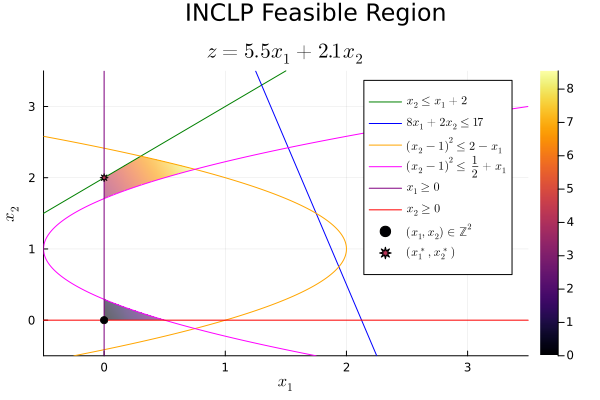

In [29]:
plot_incnlp(; sol = incnlp_x)

We are able to solve non-convex MINLP problems. However, the complexity of these problems leads to significant computational challenges that need to be tackled.

# References

- [Julia Colab Notebook Template](https://colab.research.google.com/github/ageron/julia_notebooks/blob/master/Julia_Colab_Notebook_Template.ipynb)
- [QuIPML22](https://github.com/bernalde/QuIPML22/)

<a name="installation" id="installation"></a>

# Installation

## Colab Instructions

1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. Switch to the Julia kernel: Go to _Runtime_ > _Change runtime type_ > select **Julia** (Colab now supports Julia natively).


## Local Installation Instructions

If you don't have a Julia installation yet, consider using [juliaup](https://github.com/JuliaLang/juliaup).
Otherwise, run the next cell to install the necessary packages.

### Validate Julia Installation

In [ ]:
versioninfo()

### Install Julia Packages

In [37]:
import Pkg

Pkg.activate(@__DIR__)

# Downloads all the dependencies contained in "Project.toml"
Pkg.instantiate(;io = devnull) # Suppress Output

## Installing Powerful commercial solvers

### Gurobi

Gurobi is one of the most powerful LP and MIP solvers available today.
They provide free academic licenses.
In order to install the software, visit their **[Website](https://www.gurobi.com/)**, create an account (preferably with your academic email), and obtain a license.
Once you do that, you can download and use the software.

### BARON

BARON is one of the most powerful MINLP solvers available today.
Students from the University System of Georgia or CMU and UIUC affiliates are eligible for a free license. 
In order to install the software, visit their **[Website](https://www.minlp.com/home)**, create an account (with your academic email), and obtain a license.
Once you do that you can download and use the software.

<div align="center">
    <a href="#top">🔝 Go back to the top 🔝</a>
</div>